# Partitioned Circuit Extraction Walkthrough

Final phase of the circuit partioning framework is the extraction of a partitioned quanutm circuit. 

Using the QuantumCircuitHyperGraph object and a node assignment function, we can infer the required teleportation operations and build a quantum cirucit.
The qubits are split across multiple registers - one for each partition. Each partition is also initialised with a communication qubit register and a classical bit register for facilitating the teleportation. Additional communication qubits may be added if there are not enough available.

## Build initial circuit

First build/import and transpile the circuit. We use a fixed depth random circuit as an example.

In [1]:
from disqco.circuits.cp_fraction import cp_fraction
from disqco.circuits.QAOA import QAOA_random
from disqco.graphs.GCP_hypergraph import QuantumCircuitHyperGraph
from qiskit import transpile
from disqco.parti.FM.FM_methods import set_initial_partitions
from qiskit.circuit.library import QFT, QuantumVolume, EfficientSU2
from disqco.utils.qiskit_to_op_list import *
from qiskit import QuantumCircuit
import numpy as np

num_qubits = 8

circuit = cp_fraction(  num_qubits = num_qubits,
                        depth = 2*num_qubits,
                        fraction= 0.5)

# circuit = QuantumVolume(num_qubits, 10)
# circuit = QAOA_random(num_qubits, prob=0.5, reps=1)

num_qubits = circuit.num_qubits

circuit = transpile(circuit, basis_gates=['u', 'cp'])
depth = circuit.depth()


## Graph building

We then build the graph using the QuantumCircuitHyperGraph object. We also define the paremeteres of the QPU architecture using the qpu_info and comm_info variables, which tell us how many physical qubits are in each partition.

We can draw the resulting graph using matplotlib. 

In [2]:

num_partitions = 2
qpu_size = int(num_qubits / num_partitions) + 1
qpu_info = [qpu_size] * num_partitions

comm_info = [1] * num_partitions

group_gates = True

graph = QuantumCircuitHyperGraph(circuit = circuit,
                                 group_gates = group_gates,
                                 anti_diag = True)


from disqco.graphs.quantum_network import QuantumNetwork

qnet = QuantumNetwork(qpu_info)

assignment = set_initial_partitions(network = qnet, 
                                    num_qubits = num_qubits, 
                                    depth = depth)

from disqco.parti.FM.FM_methods import calculate_full_cost

cost = calculate_full_cost(graph, assignment, num_partitions)

print("E-bit cost for unoptimised assignment: ", cost)




E-bit cost for unoptimised assignment:  13


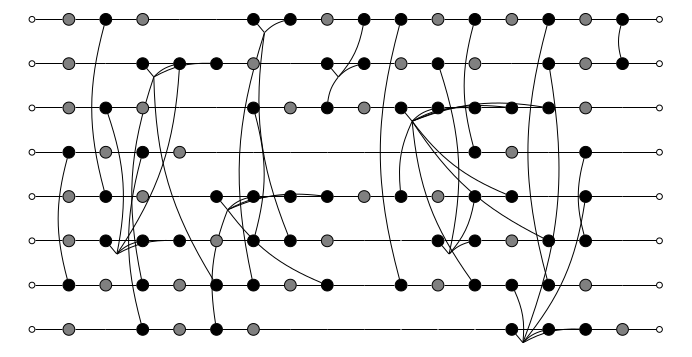

In [3]:
from disqco.drawing.tikz_drawing import *
from disqco.drawing.mpl_drawing import *
%load_ext jupyter_tikz


fig = draw_graph_tikz(H=graph,assignment=assignment,qpu_info=qpu_info)

display(fig)


## Naive extraction

We can first set a baseline for the distributed circuit by extracting a partitioned circuit directly from the unoptimised assignment function. This will likely result in a very deep circuit which does not use entanglement efficiently.

First import the extractor class, passing in the graph and the partition assignment that we initialised before.

In [4]:
from disqco.circuit_extraction.circuit_extractor import PartitionedCircuitExtractor



extractor = PartitionedCircuitExtractor(graph=graph, 
                                         partition_assignment=assignment, 
                                         qpu_info=qpu_info, 
                                         comm_info=comm_info)



basic_partitioned_circuit = extractor.extract_partitioned_circuit()

basic_partitioned_circuit_EPR = transpile(basic_partitioned_circuit, basis_gates=['cp','u','EPR'])

print(f"Depth of partitioned circuit: {basic_partitioned_circuit.depth()}")

EPR_count = basic_partitioned_circuit_EPR.count_ops()['EPR']
print(f"EPR count in partitioned circuit: {EPR_count}")



Depth of partitioned circuit: 27
EPR count in partitioned circuit: 13


We can draw the circuit to see where the teleportation blocks are occurring.

In [5]:
if num_qubits < 12:
    fig = basic_partitioned_circuit.draw(output='mpl', style='bw', fold=100)
    fig.show()


/Users/ftb123/MLQCP_FM/.venv/lib/python3.13/site-packages/qiskit/circuit/quantumcircuit.py:3394: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  return circuit_drawer(
/var/folders/s5/7cd6cqh90fd7qlk1kl1bnr0w0000gp/T/ipykernel_38176/730008554.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


To compare with original, we can transpile back into the U, CP gate-set, while choosing not to decompose the elementary entanglement generation options.

In [6]:
decomposed_circuit = transpile(basic_partitioned_circuit, basis_gates = ['cp', 'u', 'EPR'])

print(f"Depth of decomposed partitioned circuit: {decomposed_circuit.depth()}")

Depth of decomposed partitioned circuit: 94


We now optimise the node assignments using the recursive multilevel partitioning FM algorithm.

Initial cost: 13
All passes complete.
Final cost: 8
Best cost at level 0: 8
Initial cost: 8
All passes complete.
Final cost: 7
Best cost at level 1: 7
Initial cost: 7
All passes complete.
Final cost: 7
Best cost at level 2: 7
Initial cost: 7
All passes complete.
Final cost: 8
Best cost at level 3: 7
Initial cost: 7
All passes complete.
Final cost: 7
Best cost at level 4: 7


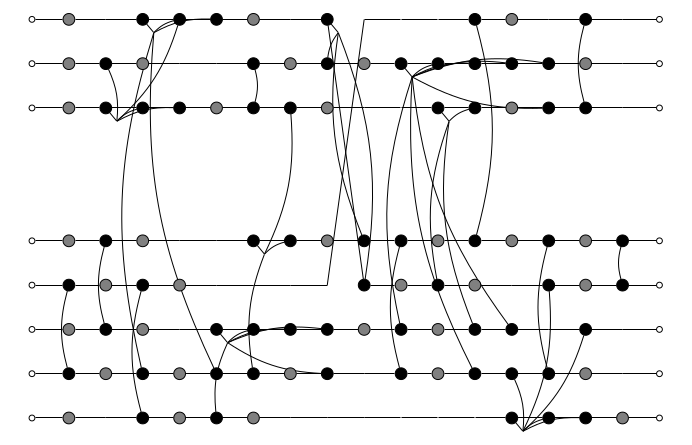

In [7]:
from disqco.parti.FM.multilevel_FM import MLFM_recursive
import numpy as np
from disqco.parti.FM.FM_main import run_FM

assignment_list, cost_list, _ = MLFM_recursive(
    graph,
    assignment,
    qpu_info,
    limit = num_qubits,
    log = True)


final_cost = min(cost_list)
final_assignment = assignment_list[np.argmin(cost_list)]

fig = draw_graph_tikz(H=graph,assignment=final_assignment,qpu_info=qpu_info)

display(fig)

Now define a new extractor for with the optimised assignment. 

In [8]:
from disqco.circuit_extraction.circuit_extractor import PartitionedCircuitExtractor

extractor_opt = PartitionedCircuitExtractor(graph = graph, 
                                            partition_assignment = final_assignment, 
                                            qpu_info = qpu_info, 
                                            comm_info=comm_info)

partitioned_circuit_opt = extractor_opt.extract_partitioned_circuit()


print(f"Depth of optimised partitioned circuit: {partitioned_circuit_opt.depth()}")

partitioned_circuit_opt_EPR = transpile(partitioned_circuit_opt, basis_gates = ['cp', 'u', 'EPR'])

if 'EPR' in partitioned_circuit_opt_EPR.count_ops():
    EPR_count_opt = partitioned_circuit_opt_EPR.count_ops()['EPR']
else:
    EPR_count_opt = 0

print(f"EPR count in optimised partitioned circuit: {EPR_count_opt}")




Depth of optimised partitioned circuit: 27
EPR count in optimised partitioned circuit: 7


In [9]:
decomposed_circuit_opt = transpile(partitioned_circuit_opt, basis_gates = ['cp', 'u', 'EPR'])
print(f"Depth of decomposed partitioned circuit: {decomposed_circuit_opt.depth()}")

if num_qubits < 12:
    fig = partitioned_circuit_opt.draw(output='mpl', style='bw', fold=100)
    fig.show()

Depth of decomposed partitioned circuit: 78


/var/folders/s5/7cd6cqh90fd7qlk1kl1bnr0w0000gp/T/ipykernel_38176/490576410.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


The depth of the resulting circuit should significantly lower than the unoptimised variant, though of course still much larger than the un-partitioned circuit. Some additional overhead is unavoidable.

## Validation

We would like to validate the output given by the partitioned circuit, which we can do using qiskits sampler class.

First we need to add measurements to the original, unpartitioned circuit.

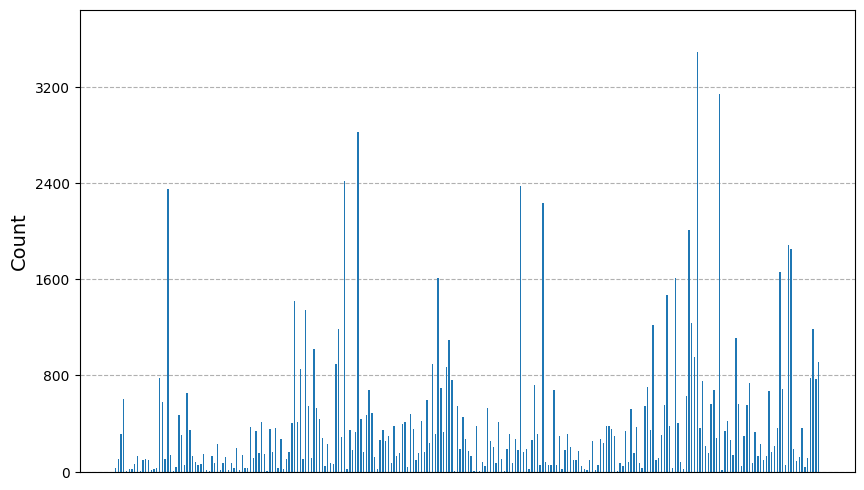

In [10]:
from disqco.circuit_extraction.verification import run_sampler, plot, get_fidelity

circuit.measure_all()

data_circuit = run_sampler(circuit, shots=100000)
plot(data_circuit)



In [11]:
data_partitioned_circuit = run_sampler(basic_partitioned_circuit, shots=100000)
plot(data_partitioned_circuit)


Too many qubits
No data to plot


In [12]:
data_partitioned_circuit_optimised = run_sampler(partitioned_circuit_opt, shots=100000)
plot(data_partitioned_circuit_optimised)

Too many qubits
No data to plot


In [13]:
fidelity = get_fidelity(data_circuit, data_partitioned_circuit, shots=100000)

print(f"Fidelity between original and unoptimised partitioned circuit: {fidelity}")

No data to compare
Fidelity between original and unoptimised partitioned circuit: None


In [14]:
fidelity = get_fidelity(data_circuit, data_partitioned_circuit_optimised, shots=100000)

print(f"Fidelity between original and optimised partitioned circuit: {fidelity}")

No data to compare
Fidelity between original and optimised partitioned circuit: None
